## Libraries

In [2]:
# Libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.linalg import null_space, det
from tentacles import *
import itertools
import os
from tqdm import tqdm # type: ignore
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy
from pymoo.core.problem import ElementwiseProblem # type: ignore
from pymoo.algorithms.moo.nsga2 import NSGA2 # type: ignore
from pymoo.optimize import minimize # type: ignore
from pymoo.visualization.scatter import Scatter # type: ignore
from pymoo.termination import get_termination
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

## First dataset creation (for coarse optimization)

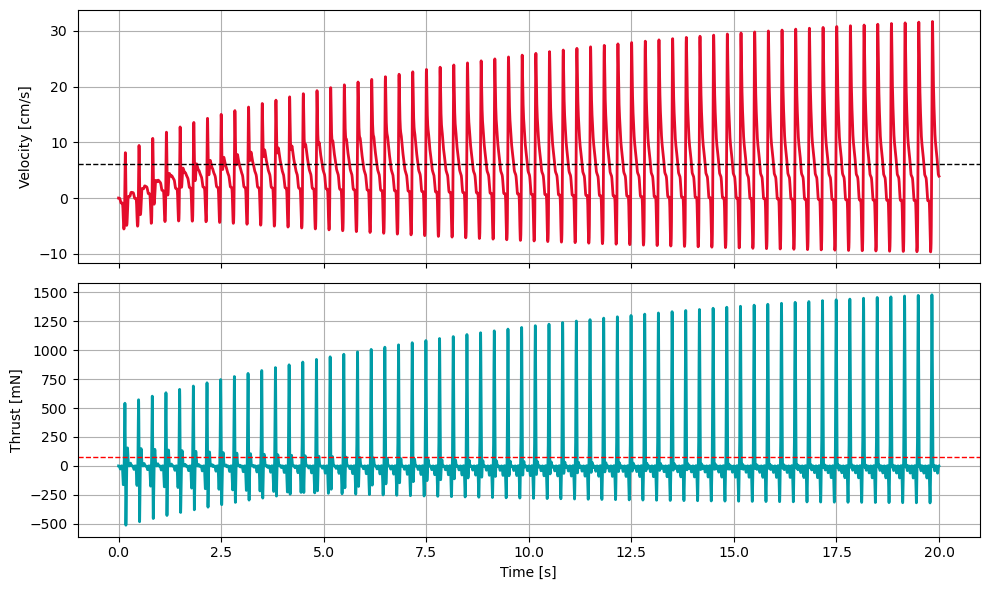

In [2]:
L = 0.5
c = 0.5
f = 3
A = np.deg2rad(45)

if True:
    thrust, velocity = NVE(L, c, f, A, plot=True)

In [10]:
def simulate_and_extend_dataset(points, dataset_path=None):
    """
    Simulates a list of parameter points and optionally appends the results
    to an existing dataset.

    Args:
        points (np.ndarray): array of shape (N, 4) with parameters [L, c, f, A].
        dataset_path (str or None): if provided, loads and extends the dataset at this path,
                                    otherwise creates a new one.

    Returns:
        inputs_tensor (torch.Tensor): tensor of shape (N_total, 4).
        outputs_tensor (torch.Tensor): tensor of shape (N_total, 2).
    """
    inputs = []
    outputs = []

    # Run simulations
    for L, c, f, A in tqdm(points, desc="Simulating NVE points"):
        try:
            thrust, velocity = NVE(L, c, f, A, plot=False)
            inputs.append([L, c, f, A])
            outputs.append([thrust, velocity])
        except Exception:
            continue  # Skip failed simulation

    # Convert to tensors
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    outputs_tensor = torch.tensor(outputs, dtype=torch.float32)

    # Optionally extend existing dataset
    if dataset_path and os.path.exists(dataset_path):
        existing = torch.load(dataset_path)
        inputs_tensor = torch.cat([existing["inputs"], inputs_tensor], dim=0)
        outputs_tensor = torch.cat([existing["outputs"], outputs_tensor], dim=0)

    # Save updated dataset
    if dataset_path:
        torch.save({"inputs": inputs_tensor, "outputs": outputs_tensor}, dataset_path)
        print(f"\n Updated dataset saved to {dataset_path}")

In [4]:
# Discretization for initial grid sampling
discretization = 2

# Define parameter ranges
L_range = np.linspace(0.1, 1.5, discretization)
c_range = np.linspace(0.0, 1.0, discretization)
f_range = np.linspace(0.05, 10.0, discretization)
A_range_deg = np.linspace(5, 120, discretization)
A_range_rad = np.deg2rad(A_range_deg)

# Generate all parameter combinations
param_grid = np.array(list(itertools.product(L_range, c_range, f_range, A_range_rad)))

# Run simulations and save dataset
if True:
    simulate_and_extend_dataset(
        points=param_grid,
        dataset_path="nve_dataset.pt"
    )

Simulating NVE points: 100%|██████████| 16/16 [12:56<00:00, 48.52s/it]


 Updated dataset saved to nve_dataset.pt


In [11]:
class NVEModel_norm(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

class NVEModel(nn.Module):
    def __init__(self, model, y_min, y_max):
        super().__init__()
        self.model = model
        self.y_min = nn.Parameter(y_min, requires_grad=False)
        self.y_max = nn.Parameter(y_max, requires_grad=False)

    def forward(self, x):
        y_norm = self.model(x)
        return y_norm * (self.y_max - self.y_min) + self.y_min

In [12]:
def train_nve_model_from_dataset(dataset_path="nve_dataset.pt"):
    """
    Trains a neural network on the normalized NVE dataset.
    Saves the final model if requested. Returns it only if not saving.

    Args:
        dataset_path (str): path to the .pt file containing {"inputs": X, "outputs": y}.
        save_model (bool): if True, saves the trained model to disk and returns nothing.

    Returns:
        model_with_denorm (nn.Module)
    """
    # Load dataset
    data = torch.load(dataset_path)
    X = data["inputs"]
    y_raw = data["outputs"]

    # Normalize outputs
    y_min = y_raw.min(dim=0).values
    y_max = y_raw.max(dim=0).values
    y_norm = (y_raw - y_min) / (y_max - y_min)

    # Split into training and validation sets
    num_samples = X.shape[0]
    split_idx = int(0.9 * num_samples)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y_norm[:split_idx], y_norm[split_idx:]

    # Create DataLoaders
    dataset_train = TensorDataset(X_train, y_train)
    dataset_val = TensorDataset(X_val, y_val)
    loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
    loader_val = DataLoader(dataset_val, batch_size=64, shuffle=False)

    model = NVEModel_norm()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop with early stopping
    epochs = 300
    patience = 20
    best_val_loss = float('inf')
    best_model = None
    wait = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        for xb, yb in loader_train:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item() * xb.size(0)
        train_losses.append(loss_epoch / len(loader_train.dataset))

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for xb, yb in loader_val:
                pred = model(xb)
                val_loss += criterion(pred, yb).item() * xb.size(0)
        val_loss /= len(loader_val.dataset)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    # Load best model weights
    model.load_state_dict(best_model)

    model_with_denorm = NVEModel(model, y_min, y_max)

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (normalized)')
    plt.legend()
    plt.grid(True)
    plt.title("Training and Validation Loss")
    plt.show()

    # Save or return
    torch.save(model_with_denorm, "nve_model.pt")
    print("Entire model saved to nve_model.pt")

    return model_with_denorm

In [ ]:
# Define the multi-objective problem
class NVEOptimizationProblem(ElementwiseProblem):
    def __init__(self, model):
        super().__init__(n_var=4, n_obj=2, n_constr=0,
                         xl=np.array([0.1, 0.0, 0.1, np.deg2rad(10)]),
                         xu=np.array([1.5, 1.0, 10.0, np.deg2rad(120)]))
        self.model = model

    def _evaluate(self, x, out, *args, **kwargs):
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            pred = self.model(x_tensor).squeeze(0).numpy()

        # Objectives: we want to maximize both → negate them for minimization
        out["F"] = - pred  # [thrust, velocity]

## Active learning for model refinement

In [14]:
def sample_around_pareto(pareto_points, N_new, sigma, bounds, max_attempts=50):
    """
    Sample points around Pareto front with Gaussian noise, ensuring all samples stay within bounds.
    If sampling fails after `max_attempts`, the original point is used.
    """
    lower, upper = np.array(bounds[0]), np.array(bounds[1])
    M = len(pareto_points)
    n_per_point = max(1, N_new // M)
    samples = []

    for x in pareto_points:
        count = 0
        while count < n_per_point:
            for attempt in range(max_attempts):
                noise = np.random.normal(0, sigma, size=(1, 4))
                perturbed = x + noise
                if np.all(perturbed >= lower) and np.all(perturbed <= upper):
                    samples.append(perturbed[0])
                    break
            else:
                # After max_attempts, use the original point
                samples.append(x)
            count = count + 1

    return np.array(samples)[:N_new]


In [15]:
def iterative_pareto_refinement(N_iter=5, N_new=500, sigma=0.05, dataset_path="nve_dataset.pt", pop_size=100):
    bounds = (
        np.array([0.1, 0.0, 0.05, np.deg2rad(5)]),  # lower
        np.array([1.5, 1.0, 10.0, np.deg2rad(120)])  # upper
    )

    final_pareto_X = None
    final_pareto_F = None

    for i in range(N_iter):
        print(f"\n=== Iteration {i+1}/{N_iter} ===")

        # Train model on current dataset
        model = train_nve_model_from_dataset(dataset_path)

        # Optimize current model with NSGA-II
        problem = NVEOptimizationProblem(model)
        algorithm = NSGA2(pop_size=pop_size)
        res = minimize(problem,
                       algorithm,
                       termination=get_termination("moo"),
                       seed=1,
                       save_history=False,
                       verbose=True)

        # Extract Pareto front
        pareto_X = res.X
        pareto_F = -res.F  # un-negate to get actual thrust and velocity

        # Plot current Pareto front
        plt.figure()
        plt.scatter(
        pareto_F[:, 0] * 1000,
        pareto_F[:, 1] * 100,
        s=40,
        facecolors='none',
        edgecolors='#e2001a',
        alpha=0.8
        )

        plt.xlabel("Thrust [mN]")
        plt.ylabel("Velocity [cm/s]")
        plt.title(f"Pareto Front - Iteration {i+1}")
        plt.tight_layout()
        plt.show()

        # Store final Pareto front
        final_pareto_X = pareto_X
        final_pareto_F = pareto_F

        # Sample new points around Pareto front
        new_points = sample_around_pareto(pareto_X, N_new=N_new, sigma=sigma, bounds=bounds)

        # Simulate and update dataset
        simulate_and_extend_dataset(new_points, dataset_path=dataset_path)

    # Return final Pareto front
    return final_pareto_X, final_pareto_F



=== Iteration 1/5 ===
Epoch   0 | Train Loss: 0.1928 | Val Loss: 0.2709
Epoch  10 | Train Loss: 0.0498 | Val Loss: 0.1978
Epoch  20 | Train Loss: 0.0223 | Val Loss: 0.1150
Epoch  30 | Train Loss: 0.0188 | Val Loss: 0.0966
Epoch  40 | Train Loss: 0.0148 | Val Loss: 0.0978
Epoch  50 | Train Loss: 0.0122 | Val Loss: 0.0999
Epoch  60 | Train Loss: 0.0104 | Val Loss: 0.0934
Epoch  70 | Train Loss: 0.0091 | Val Loss: 0.0928
Epoch  80 | Train Loss: 0.0080 | Val Loss: 0.0903
Epoch  90 | Train Loss: 0.0071 | Val Loss: 0.0874
Epoch 100 | Train Loss: 0.0062 | Val Loss: 0.0860
Epoch 110 | Train Loss: 0.0054 | Val Loss: 0.0849
Epoch 120 | Train Loss: 0.0046 | Val Loss: 0.0831
Epoch 130 | Train Loss: 0.0039 | Val Loss: 0.0819
Epoch 140 | Train Loss: 0.0033 | Val Loss: 0.0808
Epoch 150 | Train Loss: 0.0027 | Val Loss: 0.0799
Epoch 160 | Train Loss: 0.0022 | Val Loss: 0.0796
Epoch 170 | Train Loss: 0.0018 | Val Loss: 0.0793
Epoch 180 | Train Loss: 0.0015 | Val Loss: 0.0793
Early stopping at epoch 189

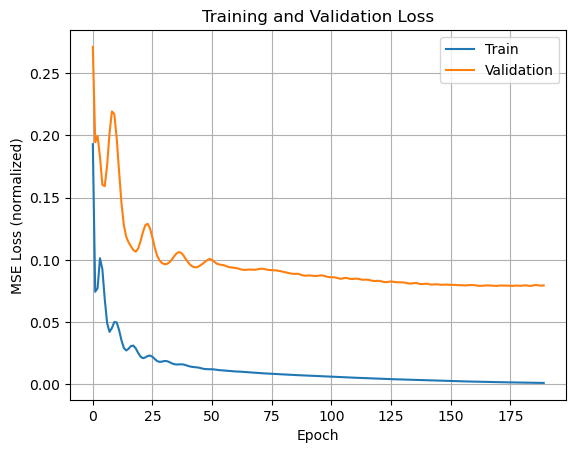

Entire model saved to nve_model.pt
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      4 |             - |             -
     2 |      200 |      5 |  0.2283755180 |         ideal
     3 |      300 |     10 |  0.1554535233 |         ideal
     4 |      400 |     12 |  0.1833016883 |         ideal
     5 |      500 |     16 |  0.1291363404 |         ideal
     6 |      600 |     23 |  0.0477767148 |         ideal
     7 |      700 |     26 |  0.0032702590 |         ideal
     8 |      800 |     41 |  0.0482650553 |         ideal
     9 |      900 |     54 |  0.0069991062 |             f
    10 |     1000 |     53 |  0.0066431451 |             f
    11 |     1100 |     58 |  0.0041160669 |         ideal
    12 |     1200 |     81 |  0.0134192651 |         ideal
    13 |     1300 |     91 |  0.0048953326 |         nadir
    14 |     1400 |    100 |  0.0029400287 |             f
    15 |     1500 |    100 |  0.0103542020 |         nadir
    16 |     1600 |  

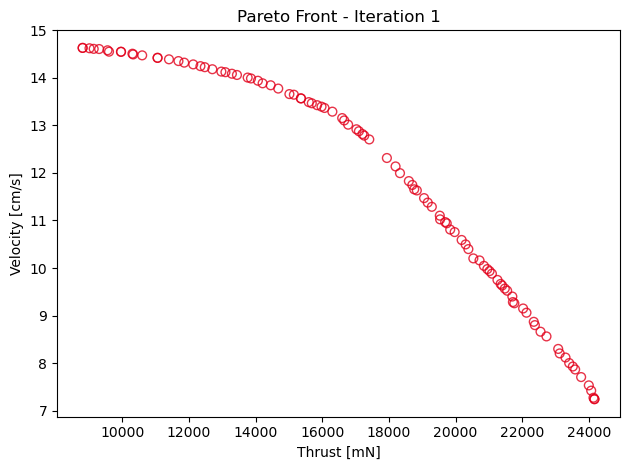

Simulating NVE points: 100%|██████████| 1/1 [00:48<00:00, 48.70s/it]



 Updated dataset saved to nve_dataset.pt

=== Iteration 2/5 ===
Epoch   0 | Train Loss: 0.2630 | Val Loss: 0.3636
Epoch  10 | Train Loss: 0.0597 | Val Loss: 0.2331
Epoch  20 | Train Loss: 0.0362 | Val Loss: 0.1586
Early stopping at epoch 22


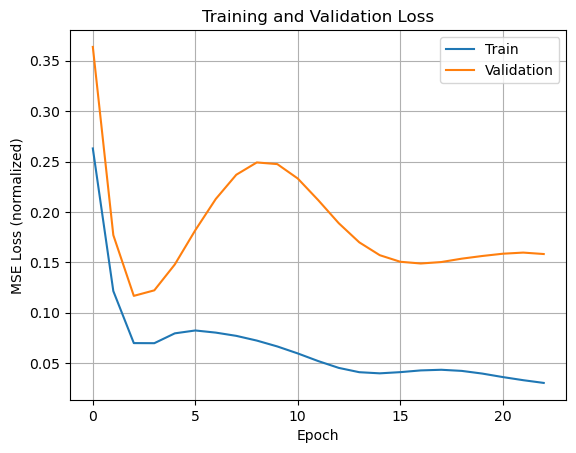

Entire model saved to nve_model.pt
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  0.3897228241 |         ideal
     3 |      300 |      1 |  0.000000E+00 |             f
     4 |      400 |      1 |  0.1250944138 |         ideal
     5 |      500 |      2 |  1.0000000000 |         ideal
     6 |      600 |      2 |  2.3764585466 |         ideal
     7 |      700 |      3 |  0.6632423322 |         ideal
     8 |      800 |      4 |  0.3705149354 |         ideal
     9 |      900 |      6 |  0.1813445202 |         ideal
    10 |     1000 |      7 |  0.3537961136 |         ideal
    11 |     1100 |      5 |  0.1306707572 |         ideal
    12 |     1200 |      7 |  0.5329975157 |         ideal
    13 |     1300 |     13 |  0.2458233360 |         ideal
    14 |     1400 |     19 |  0.1806588801 |         ideal
    15 |     1500 |     17 |  0.1906978756 |         ideal
    16 |     1600 |  

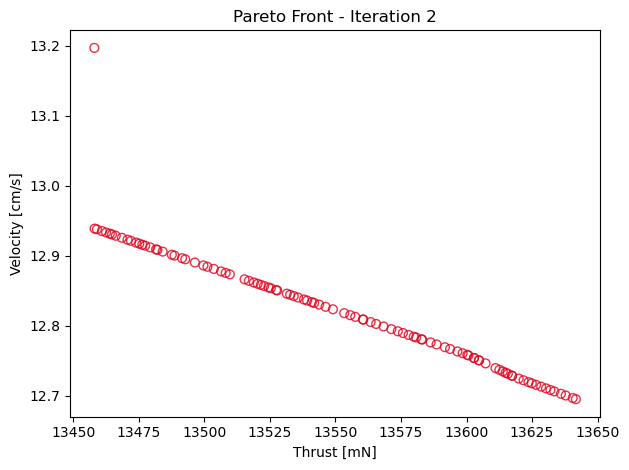

Simulating NVE points: 100%|██████████| 1/1 [01:14<00:00, 74.54s/it]



 Updated dataset saved to nve_dataset.pt

=== Iteration 3/5 ===
Epoch   0 | Train Loss: 0.1293 | Val Loss: 0.1963
Epoch  10 | Train Loss: 0.0473 | Val Loss: 0.1417
Epoch  20 | Train Loss: 0.0254 | Val Loss: 0.0866
Epoch  30 | Train Loss: 0.0165 | Val Loss: 0.0799
Epoch  40 | Train Loss: 0.0122 | Val Loss: 0.0778
Epoch  50 | Train Loss: 0.0098 | Val Loss: 0.0785
Epoch  60 | Train Loss: 0.0077 | Val Loss: 0.0810
Early stopping at epoch 62


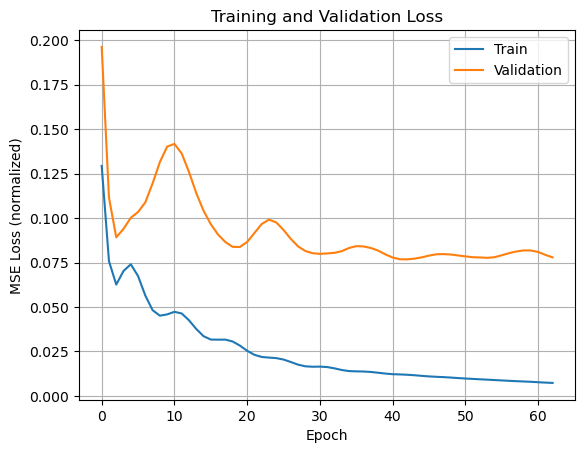

Entire model saved to nve_model.pt
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      2 |             - |             -
     2 |      200 |      5 |  0.6488825702 |         ideal
     3 |      300 |      3 |  0.2817206652 |         ideal
     4 |      400 |      6 |  0.0896635000 |         ideal
     5 |      500 |     10 |  0.1699545736 |         ideal
     6 |      600 |     16 |  0.0880802927 |         ideal
     7 |      700 |     20 |  0.0765225825 |         ideal
     8 |      800 |     28 |  0.0440805194 |         ideal
     9 |      900 |     33 |  0.0454930768 |         ideal
    10 |     1000 |     45 |  0.0332068474 |         ideal
    11 |     1100 |     50 |  0.0100212789 |             f
    12 |     1200 |     52 |  0.0078847855 |             f
    13 |     1300 |     63 |  0.0071141174 |             f
    14 |     1400 |     66 |  0.0088554021 |         ideal
    15 |     1500 |     78 |  0.0131614472 |         ideal
    16 |     1600 |  

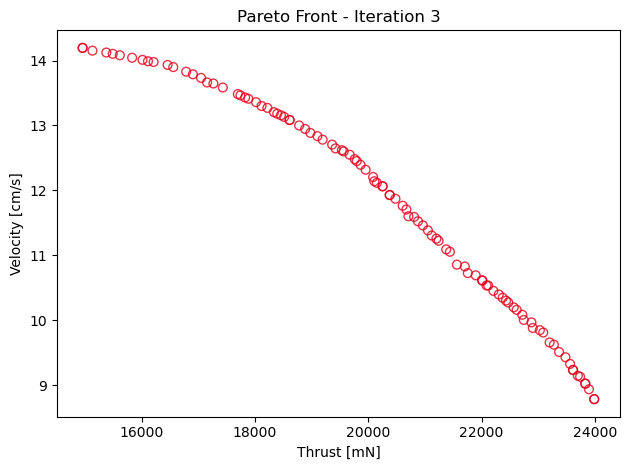

Simulating NVE points: 100%|██████████| 1/1 [02:10<00:00, 130.78s/it]



 Updated dataset saved to nve_dataset.pt

=== Iteration 4/5 ===
Epoch   0 | Train Loss: 0.1014 | Val Loss: 0.1068
Epoch  10 | Train Loss: 0.0364 | Val Loss: 0.0801
Epoch  20 | Train Loss: 0.0255 | Val Loss: 0.0698
Epoch  30 | Train Loss: 0.0221 | Val Loss: 0.0809
Epoch  40 | Train Loss: 0.0194 | Val Loss: 0.0818
Early stopping at epoch 41


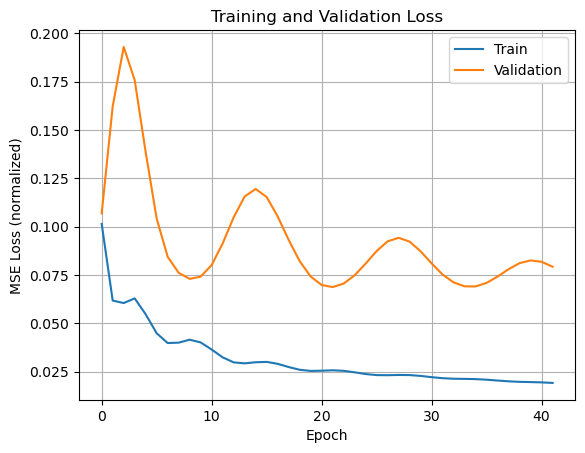

Entire model saved to nve_model.pt
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      3 |             - |             -
     2 |      200 |      4 |  0.9757847983 |         ideal
     3 |      300 |      2 |  0.3100533027 |         ideal
     4 |      400 |      5 |  0.2437373525 |         ideal
     5 |      500 |      5 |  0.3261871976 |         ideal
     6 |      600 |      4 |  0.3101111042 |         ideal
     7 |      700 |      5 |  0.2675144914 |         ideal
     8 |      800 |      9 |  0.0599718370 |             f
     9 |      900 |      9 |  0.0541623171 |         ideal
    10 |     1000 |     12 |  0.0602968070 |         ideal
    11 |     1100 |      9 |  0.1253341733 |         ideal
    12 |     1200 |     14 |  0.0396828210 |             f
    13 |     1300 |     25 |  0.0244639736 |         ideal
    14 |     1400 |     19 |  0.0076297775 |         ideal
    15 |     1500 |     28 |  0.0208451017 |             f
    16 |     1600 |  

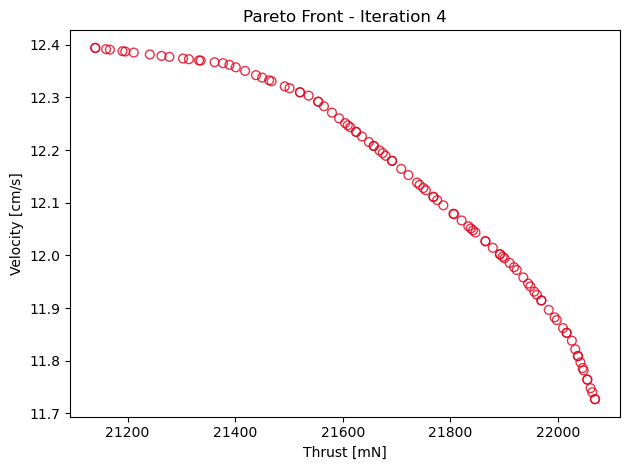

Simulating NVE points: 100%|██████████| 1/1 [00:39<00:00, 39.57s/it]



 Updated dataset saved to nve_dataset.pt

=== Iteration 5/5 ===
Epoch   0 | Train Loss: 0.3543 | Val Loss: 0.2601
Epoch  10 | Train Loss: 0.0597 | Val Loss: 0.0603
Epoch  20 | Train Loss: 0.0445 | Val Loss: 0.0514
Epoch  30 | Train Loss: 0.0342 | Val Loss: 0.0455
Epoch  40 | Train Loss: 0.0280 | Val Loss: 0.0396
Epoch  50 | Train Loss: 0.0245 | Val Loss: 0.0422
Epoch  60 | Train Loss: 0.0225 | Val Loss: 0.0437
Early stopping at epoch 61


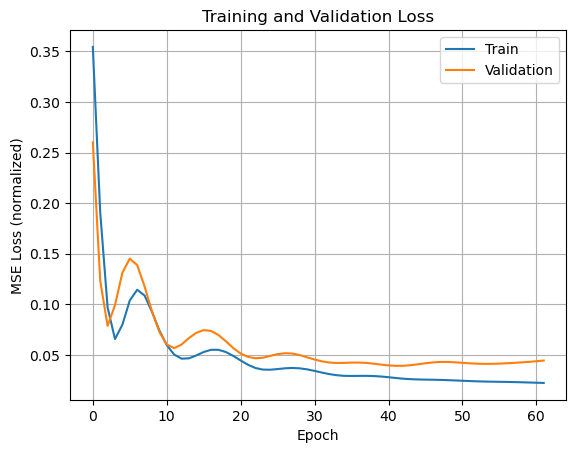

Entire model saved to nve_model.pt
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      2 |  2.2085222410 |         ideal
     3 |      300 |      4 |  0.0932524901 |         ideal
     4 |      400 |      4 |  0.3130492396 |         ideal
     5 |      500 |      8 |  0.0025840699 |         ideal
     6 |      600 |     10 |  0.1950721413 |         ideal
     7 |      700 |     19 |  0.1254709478 |         ideal
     8 |      800 |     19 |  0.0262665138 |         ideal
     9 |      900 |     28 |  0.0789368494 |         ideal
    10 |     1000 |     28 |  0.0782101727 |         nadir
    11 |     1100 |     30 |  0.0288882877 |         ideal
    12 |     1200 |     38 |  0.0038865218 |         ideal
    13 |     1300 |     47 |  0.0134911329 |         ideal
    14 |     1400 |     54 |  0.0076119020 |         ideal
    15 |     1500 |     71 |  0.0046317327 |             f
    16 |     1600 |  

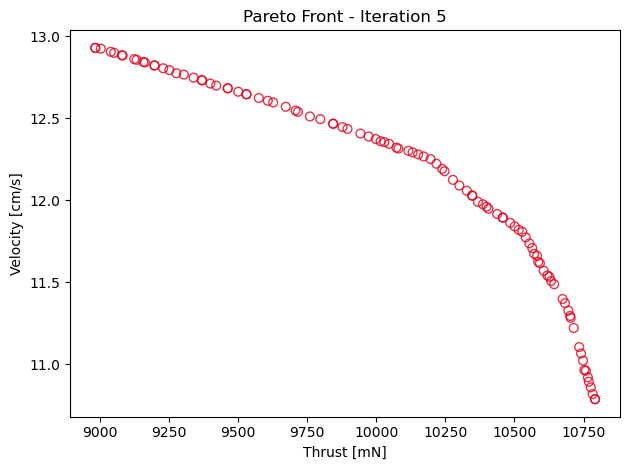

Simulating NVE points: 100%|██████████| 1/1 [00:45<00:00, 45.86s/it]


 Updated dataset saved to nve_dataset.pt


In [16]:
# Application of Pareto front
X_pareto, F_pareto = iterative_pareto_refinement(
    N_iter=5,
    N_new=1,
    sigma=np.array([0.2, 0.2, 0.4, np.deg2rad(10)]),
    dataset_path="nve_dataset.pt"
)

In [19]:
# Compute criteria
thrusts = F_pareto[:, 0]
velocities = F_pareto[:, 1]
powers = thrusts * velocities

# Maximum indeces
idx_thrust = thrusts.argmax()
idx_velocity = velocities.argmax()
idx_power = powers.argmax()

# Print
print("Best by THRUST:")
L, c, f, A = X_pareto[idx_thrust]
print(f"L={L:.3f}, c={c:.3f}, f={f:.3f}, A={np.rad2deg(A):.1f}° → Thrust={thrusts[idx_thrust]:.4f}, Velocity={velocities[idx_thrust]:.4f}")

print("\nBest by VELOCITY:")
L, c, f, A = X_pareto[idx_velocity]
print(f"L={L:.3f}, c={c:.3f}, f={f:.3f}, A={np.rad2deg(A):.1f}° → Thrust={thrusts[idx_velocity]:.4f}, Velocity={velocities[idx_velocity]:.4f}")

print("\nBest by POWER (Thrust*Velocity):")
L, c, f, A = X_pareto[idx_power]
print(f"L={L:.3f}, c={c:.3f}, f={f:.3f}, A={np.rad2deg(A):.1f}° → Thrust={thrusts[idx_power]:.4f}, Velocity={velocities[idx_power]:.4f}, Power={powers[idx_power]:.4f}")


Best by THRUST:
L=2.000, c=1.000, f=10.000, A=80.0° → Thrust=10.7916, Velocity=0.1079

Best by VELOCITY:
L=2.000, c=0.000, f=6.543, A=80.0° → Thrust=8.9838, Velocity=0.1293

Best by POWER (Thrust*Velocity):
L=2.000, c=0.006, f=8.971, A=80.0° → Thrust=10.1967, Velocity=0.1225, Power=1.2493
